SVM implementation for Lung Image Classification

In [4]:
#importing relevant libraries required for code execution
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
####
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib
####
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
from PIL import Image
from skimage.feature import hog
from skimage.color import rgb2grey
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import BaggingClassifier 
from sklearn.decomposition import PCA

In [3]:
!pip install plotly

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11435 sha256=1fc9265d2b24edb29adb632856aab788f48ac9fe0a805b25a57f8700d007a93c
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [2]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib


ModuleNotFoundError: No module named 'plotly'

In [9]:
!pip install imutils
import imutils

Defining the functions to extract features from the images

In [5]:
#creating feature vector from pixel values by resizing size
def image_to_feature_vector(image, size=(32, 32)):
    return cv2.resize(image, size).flatten()
#creating feature vector from color histogram
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,[0, 180, 0, 256, 0, 256])
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    else:
        cv2.normalize(hist, hist)
    return hist.flatten() # return the flattened histogram as the feature vector

In [6]:
#creating imagePath array by concatenating paths of all images
imagePaths = []

for dirname, _, filenames in os.walk('Covid_data/COVID-19 Radiography Database/'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

#Checking to validate all imagePaths have been included
len(imagePaths)

3886

In [7]:
len(imagePaths)

3886

In [10]:
# defining the arrays to store the feature vectors and labels
rawImages = []
features = []
labels = []
img=[]

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    pixels = image_to_feature_vector(image) #function call to first feature extraction method
    hist = extract_color_histogram(image)
    rawImages.append(pixels) #first feature vector
    features.append(hist) #second feature vector
    labels.append(label)
    img.append(image)
    
rawImages = np.array(rawImages)
features = np.array(features)
labels = np.array(labels)

Checking model performance with color histogram features with 5-fold cross validation

In [ ]:
X = pd.DataFrame(features)
y = pd.Series(labels)
svm = SVC(kernel='linear', probability=True, random_state=42) #defining the model
cv = KFold(n_splits=5, random_state=1, shuffle=True) #5-fold cross validation setup
recall = cross_val_score(svm, X, y, scoring='recall_macro', cv=cv) #calculating recall 
print("Recall: ",np.mean(recall))
precision = cross_val_score(svm, X, y, scoring='precision_macro', cv=cv) #calculating precision
print("Precision: ",np.mean(precision))
accuracy = cross_val_score(svm, X, y, scoring='accuracy', cv=cv) #calculating accuracy
print("Accuracy: ",np.mean(accuracy))
f1score = cross_val_score(svm, X, y, scoring='f1_macro', cv=cv) #calculating f1score
print("F1 Score: ",np.mean(f1score))

In [ ]:
#Plotting the model performance metrics 
svm_metrics = ['Accuracy', 'Recall', 'Precision', 'F1-Score']
svm_metric_values = [np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(f1score)]
svm_pos = [i for i, _ in enumerate(svm_metrics)]
plt.bar(svm_pos, svm_metric_values , color='green')
plt.xlabel("Percentage values")
plt.ylabel("Metrics")
plt.title("Performance metrics for SVM")
plt.xticks(svm_pos, svm_metrics)
plt.show()

Checking model performance with pixel intensity as features with 5-fold cross validation

In [ ]:
X = pd.DataFrame(rawImages)
y = pd.Series(labels)
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)
cv = KFold(n_splits=5, random_state=1, shuffle=True)
recall = cross_val_score(svm, X, y, scoring='recall_macro', cv=cv)
print("Recall: ",np.mean(recall))
precision = cross_val_score(svm, X, y, scoring='precision_macro', cv=cv)
print("Precision: ",np.mean(precision))
accuracy = cross_val_score(svm, X, y, scoring='accuracy', cv=cv)
print("Accuracy: ",np.mean(accuracy))
f1score = cross_val_score(svm, X, y, scoring='f1_macro', cv=cv)
print("F1 Score: ",np.mean(f1score))


In [11]:
X = pd.DataFrame(rawImages)
y = pd.Series(labels)
X_images = X[X.columns[::3]]
X_train, X_test, y_train, y_test = train_test_split(X_images, y, test_size=0.20, random_state=42)

In [ ]:
# Standardize the data
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(train)

# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

In [ ]:
trace1 = go.Scatter(
    x=list(range(1024)),
    y= cum_var_exp,
    mode='lines+markers',
    name="'Cumulative Explained Variance'",
#     hoverinfo= cum_var_exp,
    line=dict(
        shape='spline',
        color = 'goldenrod'
    )
)
trace2 = go.Scatter(
    x=list(range(1024)),
    y= var_exp,
    mode='lines+markers',
    name="'Individual Explained Variance'",
#     hoverinfo= var_exp,
    line=dict(
        shape='linear',
        color = 'black'
    )
)
fig = tls.make_subplots(insets=[{'cell': (1,1), 'l': 0.7, 'b': 0.5}],
                          print_grid=True)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2,1,1)
fig.layout.title = 'Explained Variance plots - Full and Zoomed-in'
fig.layout.xaxis = dict(range=[0, 80], title = 'Feature columns')
fig.layout.yaxis = dict(range=[0, 60], title = 'Explained Variance')
# fig['data'] = []
# fig['data'].append(go.Scatter(x= list(range(784)) , y=cum_var_exp, xaxis='x2', yaxis='y2', name = 'Cumulative Explained Variance'))
# fig['data'].append(go.Scatter(x= list(range(784)) , y=cum_var_exp, xaxis='x2', yaxis='y2', name = 'Cumulative Explained Variance'))

# fig['data'] = go.Scatter(x= list(range(784)) , y=cum_var_exp, xaxis='x2', yaxis='y2', name = 'Cumulative Explained Variance')]
# fig['data'] += [go.Scatter(x=list(range(784)), y=var_exp, xaxis='x2', yaxis='y2',name = 'Individual Explained Variance')]

# # fig['data'] = data
# # fig['layout'] = layout
# # fig['data'] += data2
# # fig['layout'] += layout2
py.iplot(fig, filename='test.png')

In [ ]:
# Invoke SKlearn's PCA method
n_components = 30
pca = PCA(n_components=n_components).fit(train)

eigenvalues = pca.components_.reshape(n_components, 32, 32)

# Extracting the PCA components ( eignevalues )
#eigenvalues = pca.components_.reshape(n_components, 28, 28)
eigenvalues = pca.components_

In [ ]:
n_row = 3
n_col = 3

# Plot the first 8 eignenvalues
fig = plt.figure(figsize=(13,12))
for i in list(range(n_row * n_col)):
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigenvalues[i].reshape(32,32), cmap='jet')
    title_text = 'Eigenvalue ' + str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())
plt.show()
fig.savefig('pca_images.jpeg', bbox_inches='tight')

In [ ]:
# plot some of the numbers
fig = plt.figure(figsize=(14,12))
for digit_num in range(0,6):
    plt.subplot(2,3,digit_num+1)
    grid_data = train.iloc[digit_num].values.reshape(32,32)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
fig.savefig('reduced_images.jpeg', bbox_inches='tight')

In [90]:
pca = PCA(n_components=10)
train_pca = pca.fit_transform(X_train)
test_pca = pca.transform(X_test)


In [67]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline( StandardScaler(), SVC(kernel ='linear', C =0.5, cache_size =1000, random_state=42))
clf.fit(train_pca, y_train)
lin_svm_test_acc = (y_test==clf.predict(test_pca)).mean()
lin_svm_test_acc

0.8586118251928021

Full 32 x 32 image linear svm kernel

In [53]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline( StandardScaler(), SVC(kernel ='linear', C =0.5, cache_size =1000, random_state=42))
clf.fit(X_train, y_train)
lin_svm_test_acc = (y_test==clf.predict(X_test)).mean()
lin_svm_test_acc

0.9267352185089974

In [68]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline( StandardScaler(), SVC(kernel ='rbf',  cache_size =1000, random_state=42))
clf.fit(train_pca, y_train)
rbf_svm_test_acc = (y_test==clf.predict(test_pca)).mean()
rbf_svm_test_acc

0.8946015424164524

In [57]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline( StandardScaler(), SVC(kernel ='rbf',  cache_size =1000, random_state=42))
clf.fit(X_train, y_train)
rbf_svm_test_acc = (y_test==clf.predict(X_test)).mean()
rbf_svm_test_acc

0.9473007712082262

In [69]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 20 , random_state =42)
clf.fit(train_pca, y_train)
rf_test_acc = (y_test==clf.predict(test_pca)).mean()
rf_test_acc

0.8881748071979434

In [59]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 20 , random_state =42)
clf.fit(X_train, y_train)
rf_test_acc = (y_test==clf.predict(X_test)).mean()
rf_test_acc

0.9331619537275064

In [96]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(min_impurity_decrease = 0.0001, random_state =42)
clf.fit(train_pca, y_train)
tree_test_acc = (y_test==clf.predict(test_pca)).mean()
tree_test_acc

0.8213367609254498

In [98]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has {n} nodes and has "
      "the following tree structure:\n".format(n=n_nodes))
for i in range(n_nodes):
    if is_leaves[i]:
        print("{space}node={node} is a leaf node.".format(
            space=node_depth[i] * "\t", node=i))
    else:
        print("{space}node={node} is a split node: "
              "go to node {left} if X[:, {feature}] <= {threshold} "
              "else to node {right}.".format(
                  space=node_depth[i] * "\t",
                  node=i,
                  left=children_left[i],
                  feature=feature[i],
                  threshold=threshold[i],
                  right=children_right[i]))

The binary tree structure has 655 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 0] <= 466.1468048095703 else to node 566.
	node=1 is a split node: go to node 2 if X[:, 3] <= 39.89190101623535 else to node 335.
		node=2 is a split node: go to node 3 if X[:, 9] <= 74.50404739379883 else to node 234.
			node=3 is a split node: go to node 4 if X[:, 2] <= -209.46991729736328 else to node 73.
				node=4 is a split node: go to node 5 if X[:, 1] <= 554.6291198730469 else to node 64.
					node=5 is a split node: go to node 6 if X[:, 1] <= -400.84727478027344 else to node 15.
						node=6 is a split node: go to node 7 if X[:, 5] <= -279.77874755859375 else to node 12.
							node=7 is a split node: go to node 8 if X[:, 6] <= -175.98423767089844 else to node 11.
								node=8 is a split node: go to node 9 if X[:, 7] <= 112.19138717651367 else to node 10.
									node=9 is a leaf node.
									node=10 is a leaf node.
								node=11 is a leaf node.
		

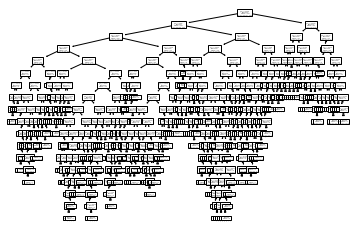

In [97]:
from sklearn import tree
tree.plot_tree(clf)
plt.show()

In [60]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(min_impurity_decrease = 0.0001, random_state =42)
clf.fit(X_train, y_train)
tree_test_acc = (y_test==clf.predict(X_test)).mean()
tree_test_acc

0.8059125964010283

In [71]:
from sklearn.neighbors import KNeighborsClassifier

clf =  KNeighborsClassifier(n_neighbors=7)
clf.fit(train_pca, y_train)
tree_test_acc = (y_test==clf.predict(test_pca)).mean()
tree_test_acc

0.8753213367609255

In [61]:
from sklearn.neighbors import KNeighborsClassifier

clf =  KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train, y_train)
tree_test_acc = (y_test==clf.predict(X_test)).mean()
tree_test_acc

0.9280205655526992

In [72]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf =  LinearDiscriminantAnalysis()
clf.fit(train_pca, y_train)
tree_test_acc = (y_test==clf.predict(test_pca)).mean()
tree_test_acc

0.8470437017994858

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf =  LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
tree_test_acc = (y_test==clf.predict(X_test)).mean()
tree_test_acc

0.897172236503856

In [73]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf =  QuadraticDiscriminantAnalysis()
clf.fit(train_pca, y_train)
tree_test_acc = (y_test==clf.predict(test_pca)).mean()
tree_test_acc

0.8688946015424165

In [63]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf =  QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
tree_test_acc = (y_test==clf.predict(X_test)).mean()
tree_test_acc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning:

Variables are collinear



0.5732647814910026

In [74]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

clf = make_pipeline( StandardScaler(), LogisticRegression(random_state = 42)) 
clf.fit(train_pca, y_train)
tree_test_acc = (y_test==clf.predict(test_pca)).mean()
tree_test_acc

0.8470437017994858

In [65]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

clf = make_pipeline( StandardScaler(), LogisticRegression(random_state = 42)) 
clf.fit(X_train, y_train)
tree_test_acc = (y_test==clf.predict(X_test)).mean()
tree_test_acc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9190231362467867

In [77]:
clf.predict(test_pca)

array(['Covid_data/COVID-19 Radiography Database/NORMAL',
       'Covid_data/COVID-19 Radiography Database/Viral Pneumonia',
       'Covid_data/COVID-19 Radiography Database/Viral Pneumonia',
       'Covid_data/COVID-19 Radiography Database/Viral Pneumonia',
       'Covid_data/COVID-19 Radiography Database/NORMAL',
       'Covid_data/COVID-19 Radiography Database/Viral Pneumonia',
       'Covid_data/COVID-19 Radiography Database/Viral Pneumonia',
       'Covid_data/COVID-19 Radiography Database/Viral Pneumonia',
       'Covid_data/COVID-19 Radiography Database/NORMAL',
       'Covid_data/COVID-19 Radiography Database/Viral Pneumonia',
       'Covid_data/COVID-19 Radiography Database/Viral Pneumonia',
       'Covid_data/COVID-19 Radiography Database/Viral Pneumonia',
       'Covid_data/COVID-19 Radiography Database/Viral Pneumonia',
       'Covid_data/COVID-19 Radiography Database/COVID',
       'Covid_data/COVID-19 Radiography Database/COVID',
       'Covid_data/COVID-19 Radiography Da

In [87]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

estimators = [
    ('lin_svm', make_pipeline( StandardScaler(), SVC(kernel ='linear', C =0.5, cache_size =1000, random_state=42))),
    ('rbf_svm', make_pipeline( StandardScaler(), SVC(kernel ='rbf',  cache_size =1000, random_state=42))),
    ('rf', RandomForestClassifier(max_depth = 20 , random_state =42)),
    ('tree', DecisionTreeClassifier(min_impurity_decrease = 0.0001, random_state =42)),
    ('knn7', KNeighborsClassifier(n_neighbors=7)),
    ('lda', LinearDiscriminantAnalysis()),
    ('qda', QuadraticDiscriminantAnalysis())
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning:

Variables are collinear

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning:

Variables are collinear

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning:

Variables are collinear

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning:

Variables are collinear

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning:

Variables are collinear

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning:

Variables are collinear

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit

In [91]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

estimators = [
    ('lin_svm', make_pipeline( StandardScaler(), SVC(kernel ='linear', C =0.5, cache_size =1000, random_state=42))),
    ('rbf_svm', make_pipeline( StandardScaler(), SVC(kernel ='rbf',  cache_size =1000, random_state=42))),
    ('rf', RandomForestClassifier(max_depth = 20 , random_state =42)),
    ('tree', DecisionTreeClassifier(min_impurity_decrease = 0.0001, random_state =42)),
    ('knn7', KNeighborsClassifier(n_neighbors=7)),
    ('lda', LinearDiscriminantAnalysis()),
    ('qda', QuadraticDiscriminantAnalysis())
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

clf.fit(train_pca, y_train)
y_pred = clf.predict(test_pca)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [92]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[246,   4,  11],
       [  4, 232,  34],
       [  2,  24, 221]], dtype=int64)

In [94]:
y_test.unique()

array(['Covid_data/COVID-19 Radiography Database/NORMAL',
       'Covid_data/COVID-19 Radiography Database/Viral Pneumonia',
       'Covid_data/COVID-19 Radiography Database/COVID'], dtype=object)

In [ ]:
#Plotting the model performance metrics 
svm_metrics = ['Accuracy', 'Recall', 'Precision', 'F1-Score']
svm_metric_values = [np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(f1score)]
svm_pos = [i for i, _ in enumerate(svm_metrics)]
plt.bar(svm_pos, svm_metric_values , color='gray')
plt.xlabel("Percentage values")
plt.ylabel("Metrics")
plt.title("Performance metrics for SVM without bagging")
plt.xticks(svm_pos, svm_metrics)
plt.show()

Checking model performance with pixel intensity as features with 5-fold cross validation and bagging with 5 estimators

In [ ]:
X = pd.DataFrame(rawImages)
y = pd.Series(labels)
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)
cv = KFold(n_splits=5, random_state=1, shuffle=True)
svm = BaggingClassifier(base_estimator=svm, n_estimators=5, random_state=314) #defining the model with bagging
recall = cross_val_score(svm, X, y, scoring='recall_macro', cv=cv)
print("Recall: ",np.mean(recall))
precision = cross_val_score(svm, X, y, scoring='precision_macro', cv=cv)
print("Precision: ",np.mean(precision))
accuracy = cross_val_score(svm, X, y, scoring='accuracy', cv=cv)
print("Accuracy: ",np.mean(accuracy))
f1score = cross_val_score(svm, X, y, scoring='f1_macro', cv=cv)
print("F1 Score: ",np.mean(f1score))

In [ ]:
svm_metrics = ['Accuracy', 'Recall', 'Precision', 'F1-Score']
svm_metric_values = [np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(f1score)]
svm_pos = [i for i, _ in enumerate(svm_metrics)]
plt.bar(svm_pos, svm_metric_values, color='green')
plt.xlabel("Percentage values")
plt.ylabel("Metrics")
plt.title("Performance metrics for SVM with bagging")

plt.xticks(svm_pos, svm_metrics)

plt.show()

In [ ]:
X = pd.DataFrame(rawImages)
y = pd.Series(labels)
# define support vector classifier
svm = SVC(kernel='rbf', probability=True, random_state=42)
cv = KFold(n_splits=5, random_state=1, shuffle=True)
svm = BaggingClassifier(base_estimator=svm, n_estimators=5, random_state=314) #defining the model with bagging
recall = cross_val_score(svm, X, y, scoring='recall_macro', cv=cv)
print("Recall: ",np.mean(recall))
precision = cross_val_score(svm, X, y, scoring='precision_macro', cv=cv)
print("Precision: ",np.mean(precision))
accuracy = cross_val_score(svm, X, y, scoring='accuracy', cv=cv)
print("Accuracy: ",np.mean(accuracy))
f1score = cross_val_score(svm, X, y, scoring='f1_macro', cv=cv)
print("F1 Score: ",np.mean(f1score))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X = pd.DataFrame(rawImages)
y = pd.Series(labels)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1,random_state=109)
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test,preds))

Evaluating model with different values of K for K-Fold cross validation

In [ ]:
splits = [x for x in range(2,7)] # define the folds for cross-validation
#create empty arrays to store the model evaluation metrics
recall_final = [] 
precision_final = []
accuracy_final = []
f1_final = []

#training and testing the model for different values of K between 2 and 6
for split in splits: 
    cv = KFold(n_splits=split, random_state=1, shuffle=True)
    recall = cross_val_score(svm, X, y, scoring='recall_macro', cv=cv)
    recall_final.append(np.mean(recall))
    precision = cross_val_score(svm, X, y, scoring='precision_macro', cv=cv)
    precision_final.append(np.mean(precision))
    accuracy = cross_val_score(svm, X, y, scoring='accuracy', cv=cv)
    accuracy_final.append(np.mean(accuracy))
    f1score = cross_val_score(svm, X, y, scoring='f1_macro', cv=cv)
    f1_final.append(np.mean(f1score))
print("Recall: ",recall_final)
print("Precision: ",precision_final)
print("Accuracy: ",accuracy_final)
print("F1 Score: ",f1_final)

In [ ]:
#plotting the model performance metrics for different values of K 
fig2 = plt.figure(figsize =(12, 7))
plt.plot(splits,recall_final, label='recall')
plt.plot(splits,precision_final, label='precision')
plt.plot(splits,accuracy_final, label='accuracy')
plt.plot(splits,f1_final, label='f1score')
plt.xlabel('Folds')
plt.ylabel('Model Evaluation Metrics')
plt.title('SVM performance obtained at different folds ')
plt.legend(loc='lower right')
plt.show()